# Modelagem de Sistemas Dinâmicos (PME3380)

Simulações dinâmicas para diferentes cenários do trabalho final da discicplina de Modelagem de Sistemas Dinâmicos da Escola Politécnica da USP.

Engenharia Mecânica,Dezembro de 2023

### Configuração do Ambiente e Bibliotecas

Importação das principais biblitoecas que vão ser utilizadas no desenvolvimento da tarefa.

- Numpy para os cálculos de álgebra linear
- Matplotlib para a criação de gráficos
- Scipy para utilizar os métodos de integração numérica



In [10]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

## Descrição do Modelo

Trata-se do controle vetorizado de empuxo para um sistema ativo de pouso de um foguete. Este é tratado como um corpo rígido, e opera segundo a dinâmica previamente calculada.

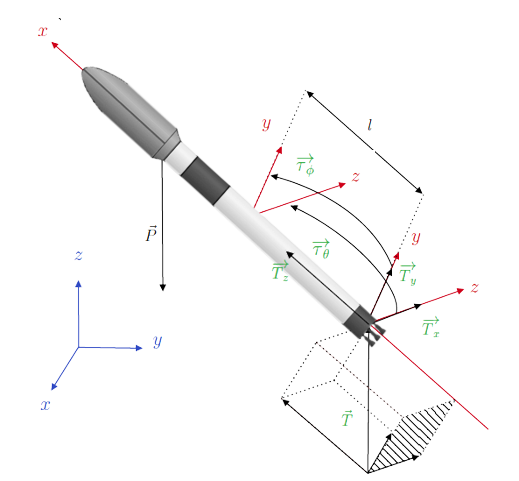

## Parâmetros do Modelo

Primeiramente, definindo as variáveis correspondentes aos parâmetros do problema, tabelados de acordo com o exposto em relatório.

In [11]:
# Definição do empuxo
T = 230.57  # N

# Constantes
g = 9.81  # m/s^2
rho = 1.091  # kg/m^3
d = 0.127  # m
S = np.pi * (d / 2)**2  # m^2
C_D = 0.432
m = 23.545  # kg
J = np.array([[0, 0, 0], [0, 15.97, 0], [0, 0, 15.97]])  # matriz de inércia (kg*m^2)
x_cp = -0.261  # m
L = 3.304  # m (comprimento de referência)
x_cm = 1.052 # m (coordenada do centro de massa)

## Transformações

In [12]:
def r1(phi):
    return np.array([[1, 0, 0],
                     [0, np.cos(phi), np.sin(phi)],
                     [0, -np.sin(phi), np.cos(phi)]])

def r2(theta):
    return np.array([[np.cos(theta), 0, -np.sin(theta)],
                     [0, 1, 0],
                     [np.sin(theta), 0, np.cos(theta)]])

def r3(psi):
    return np.array([[np.cos(psi), np.sin(psi), 0],
                     [-np.sin(psi), np.cos(psi), 0],
                     [0, 0, 1]])

#inverte matriz
def inverter_matriz(matriz):
  try:

    matriz_inversa = np.linalg.inv(matriz)

    return matriz_inversa

  except np.linalg.LinAlgError:

    return None

#fixo->móvel (mov = Rfix)
def tra_fm(fix, ang):
#lembrando que phi é roll
#theta e psi variam e são =/= 0
  phi, theta, psi = ang
  mov = r1(phi)@r2(theta)@r3(psi)
  mov = mov@fix

  return mov

#móvel->fixo (fix = R^(-1)mov)
def tra_mf(mov, ang):

  phi, theta, psi = ang
  T = inverter_matriz(r1(phi)@r2(theta)@r3(psi))
  fix = T@mov

  return fix

#matriz B
def B(ang):

    phi, theta, psi = ang
    return np.array([[1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
                     [0, np.cos(phi), -np.sin(phi)],
                     [0, np.sin(phi) * 1/np.cos(theta), np.cos(phi) * 1/np.cos(theta)]])

#omega fixo->móvel (mov = Bfix)
def tra_fm(fix, ang):

  phi, theta, psi = ang
  mov = B(ang)@fix

  return mov

#omega móvel->fixo (fix = b^(-1)mov)
def tra_mf(mov, ang):

  phi, theta, psi = ang
  fix = inverter_matriz(B(ang))@mov

  return fix


## Simulações Cinemáticas

Condições iniciais de velocidade

In [13]:
# Define três condições iniciais
# x, y, z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z 
initial_conditions_1 = [150, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0]
initial_conditions_2 = [150, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0]
initial_conditions_3 = [150, 0, 0, 0.01, 0.04, -0.05, -10, 0, 0, 0, 0.01, 0.01]

# List of initial conditions for simulation
initial_conditions_list = [initial_conditions_1, initial_conditions_2, initial_conditions_3]

### Equações Dinâmicas


Função não linearizada

In [14]:
def non_linear(t, mov):
    x, y, z, phi, theta, psi, vx, vy, vz, wx, wy, wz = mov

    # Defina suas variáveis de entrada
    alpha_y = 0.1 * np.sin(10 * t - 10 * np.pi/4)
    alpha_z = 0.1 * np.sin(10 * t - 10 * np.pi/4)

    # Equações de movimento
    ax = wz * vy - wy * vz + 1/m * (-m * g * np.cos(theta) * np.cos(psi) + T * np.cos(alpha_y) * np.cos(alpha_z) + 1/2 * rho * C_D * np.cos(theta) * np.cos(psi) *
                                      (np.pi * (d**2)/4 + L * d * ((np.sin(theta))**2 + (np.sin(psi))**2)**0.5 ) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2 )

    ay = - wz * vx + wx * vz + 1/m * ( -m * g * (np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) + T * np.cos(alpha_z) * np.sin(alpha_y) + 1/2 * rho * C_D * (np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) *
                                      (np.pi * (d**2)/4 + L * d * ((np.sin(theta))**2 + (np.sin(psi))**2)**0.5 ) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2 )

    az = wy * vx - wx * vy + 1/m * ( -m * g * (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) + T * np.cos(alpha_y) * np.sin(alpha_z) + 1/2 * rho * C_D * (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) *
                                      (np.pi * (d**2)/4 + L * d * ((np.sin(theta))**2 + (np.sin(psi))**2)**0.5 ) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2 )

    wx_dt = 0  # Adicione essa linha

    wy_dt = -1/(8 * J[1][1]) * ( 8 * wx * wz * J[2][2] + 8 * T * np.cos(alpha_y) * np.sin(alpha_z) * x_cm - rho * C_D * (2 * 2**0.5 * L * d * (2 - np.cos(2*theta) - np.cos(2*psi))**0.5 + np.pi * d**2) *
                                      (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2*x_cp)

    wz_dt = -1/(8 * J[2][2]) * (-8 * wy * wx * J[1][1] - 8 * T * np.cos(alpha_z) * np.sin(alpha_y) * x_cm + rho * C_D * (2 * 2**0.5 * L * d * (2 - np.cos(2*theta) - np.cos(2*psi))**0.5 + np.pi * d**2) *
                                      (np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2*x_cp)


    # Retorne os valores como uma lista
    return [vx, vy ,vz, wx, wy, wz, ax, ay, az, wx_dt, wy_dt, wz_dt]

Simulações dinâmicas e apresentação de resultados

In [15]:
# Loop through each set of initial conditions and simulate
t_span = [0, 30]  # Adjust the time span as needed

# Initialize vectors to store solutions
solutions = []

# Loop through each set of initial conditions and simulate
for initial_conditions in initial_conditions_list:
    solution = solve_ivp(non_linear, t_span, initial_conditions, method='RK23', t_eval=np.linspace(t_span[0], t_span[1], 500))
    solutions.append(solution)

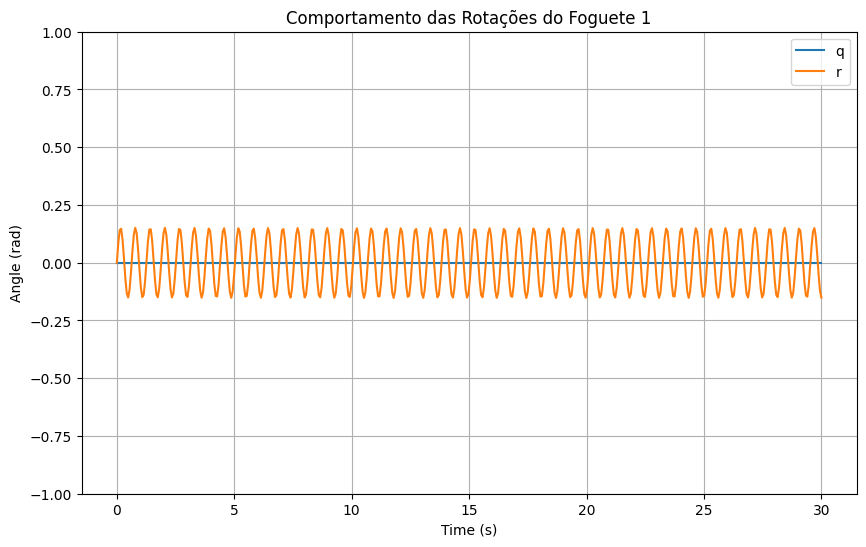

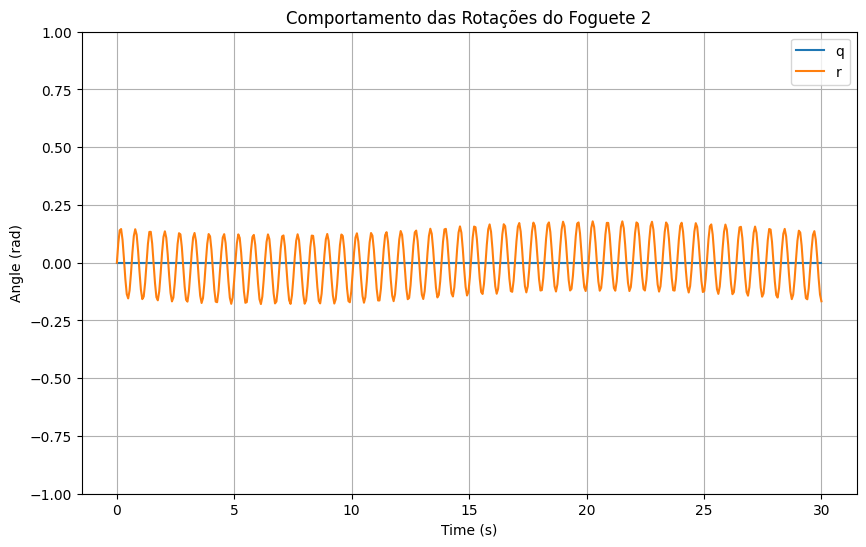

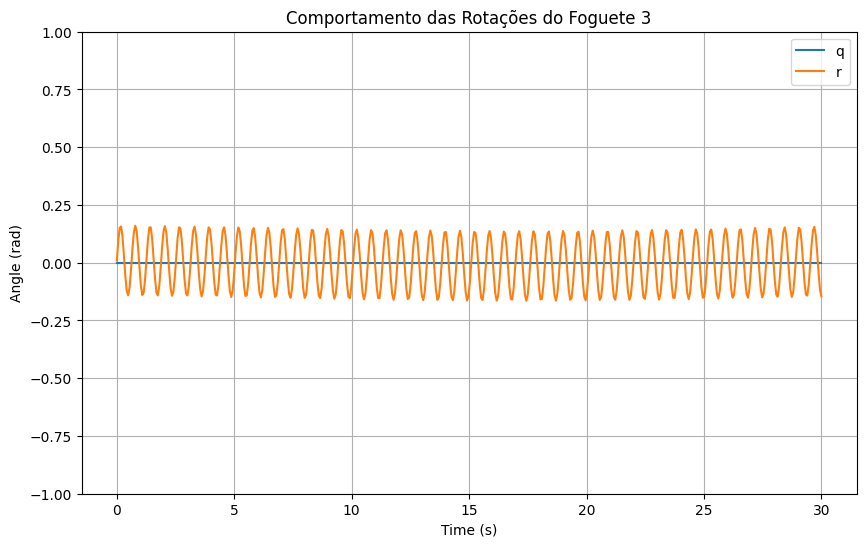

In [18]:
# Plot Euler angles over time for each scenario
for i, solution in enumerate(solutions):
    time = solution.t
    angles = solution.y[9:11, :]

    plt.figure(figsize=(10, 6))
    plt.plot(time, angles[0, :], label='q')
    plt.plot(time, angles[1, :], label='r')
    plt.title(f'Comportamento das Rotações do Foguete {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (rad)')
    plt.ylim(-1, 1)  # Set y-axis limits from -4 to 4
    plt.legend()
    plt.grid(True)
    plt.show()


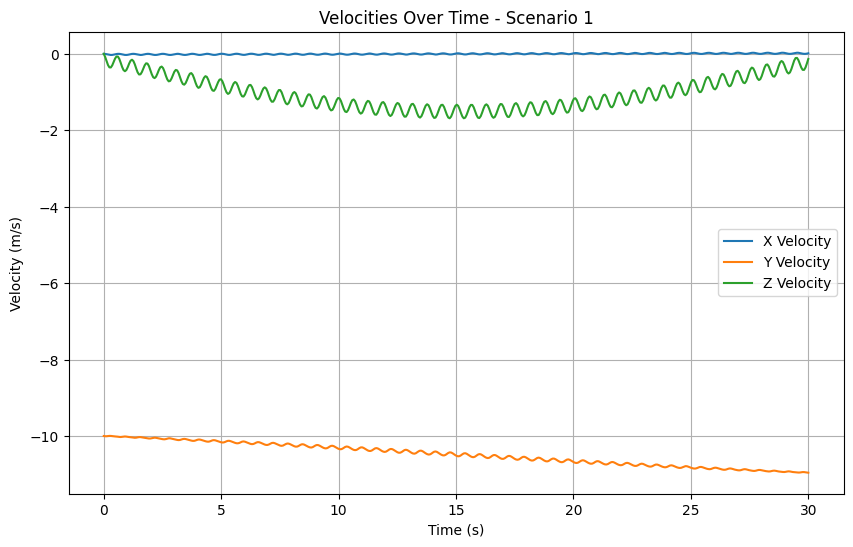

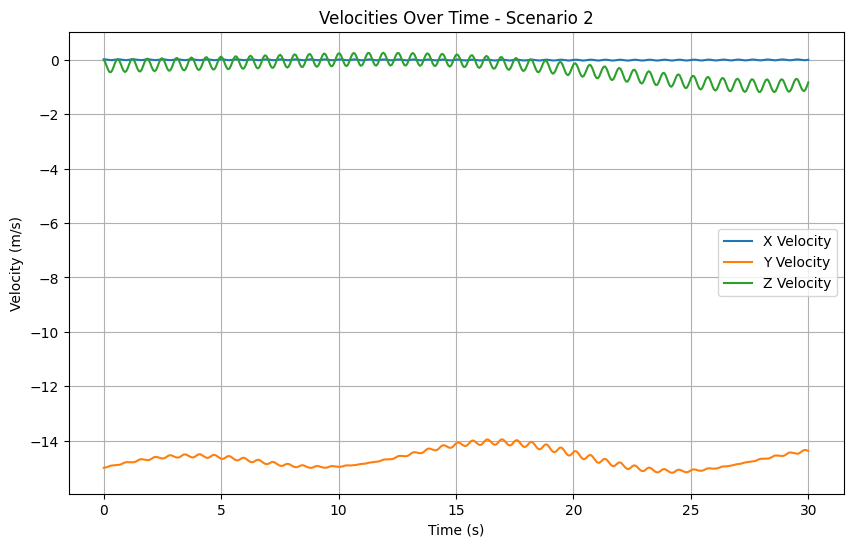

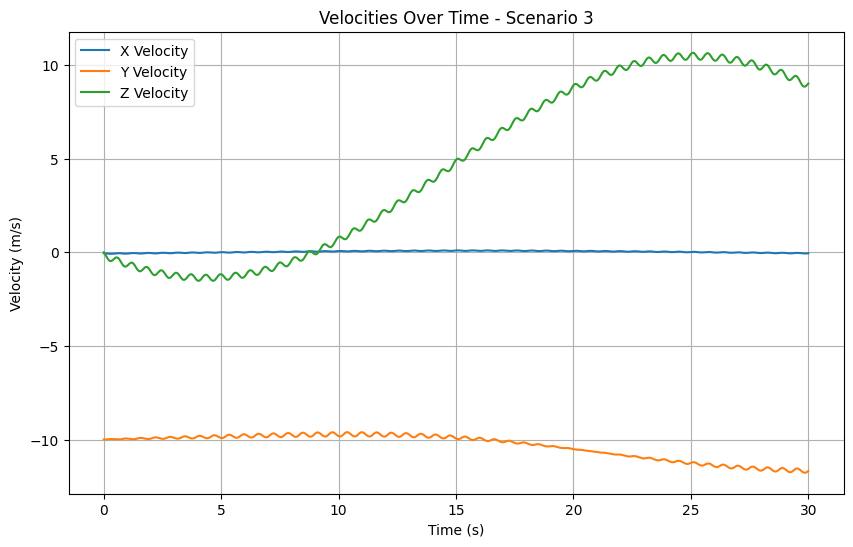

In [ ]:
# Plot velocities over time for each scenario
for i, solution in enumerate(solutions):
    time = solution.t
    velocities = solution.y[5:8, :]

    plt.figure(figsize=(10, 6))
    plt.plot(time, velocities[0, :], label='X Velocity')
    plt.plot(time, velocities[1, :], label='Y Velocity')
    plt.plot(time, velocities[2, :], label='Z Velocity')
    plt.title(f'Velocities Over Time - Scenario {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()


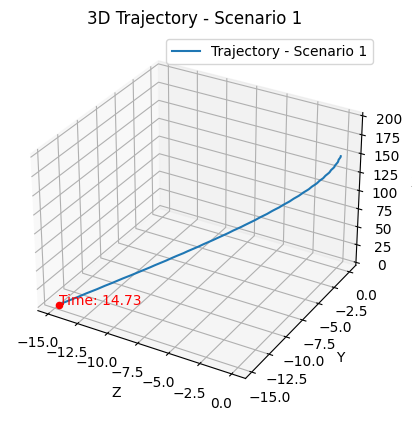

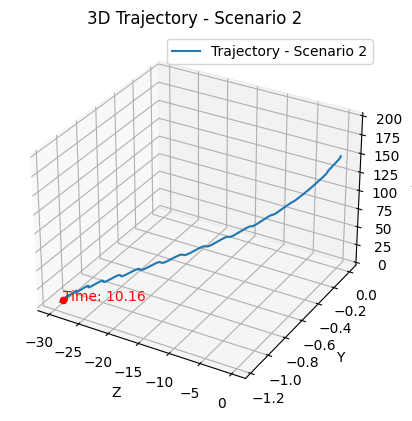

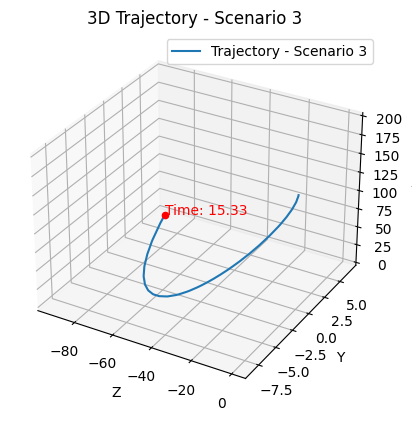

In [ ]:
# Suponha que 'solutions' seja uma lista de soluções, como você mencionou

# Plot 3D trajectories for each scenario
for i, solution in enumerate(solutions):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x_values = solution.y[0, :]
    y_values = solution.y[1, :]
    z_values = solution.y[2, :]
    
    # Filter values where z is greater than or equal to 0
    mask_positive = x_values >= 0
    z_values_positive = z_values[mask_positive]
    y_values_positive = y_values[mask_positive]
    x_values_positive = x_values[mask_positive]
    
    # Plotting the trajectory
    ax.plot(z_values_positive, y_values_positive, x_values_positive, label=f'Trajectory - Scenario {i+1}')
    
    # Finding the time when z becomes zero
    zero_crossings = np.where(np.diff(np.sign(x_values)))[0]
    for crossing in zero_crossings:
        crossing_time = np.interp(0, x_values[crossing:crossing+2], solution.t[crossing:crossing+2])
        ax.scatter(z_values[crossing], y_values[crossing], x_values[crossing], c='red', marker='o')
        ax.text(z_values[crossing], y_values[crossing], x_values[crossing],
                f'Time: {crossing_time:.2f}', color='red')
    
    # Set z-axis limits from 0 to 200
    ax.set_zlim(0, 200)
    
    ax.set_xlabel('Z')
    ax.set_ylabel('Y')
    ax.set_zlabel('X')
    ax.set_title(f'3D Trajectory - Scenario {i+1}')
    ax.legend()
    plt.show()